- Yahoo Finance 에서 주가 데이터 다운로드 (https://finance.yahoo.com/)
- 검색 후 Historical Data 선택
![image-2.png](attachment:image-2.png)

- 기간 선택 후 Apply -> Download 클릭
![image.png](attachment:image.png)

##### Data Loading 및 확인

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [7]:
df = pd.read_csv('/content/drive/MyDrive/06_딥러닝/data/005930.KS.csv')

In [10]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-04,6000.0,6110.0,5660.0,6110.0,4563.384766,74195000
1,2000-01-05,5800.0,6060.0,5520.0,5580.0,4167.541992,74680000
2,2000-01-06,5750.0,5780.0,5580.0,5620.0,4197.416992,54390000
3,2000-01-07,5560.0,5670.0,5360.0,5540.0,4137.668457,40305000
4,2000-01-10,5600.0,5770.0,5580.0,5770.0,4309.447754,46880000


In [11]:
#결측치 확인 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5814 entries, 0 to 5813
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5814 non-null   object 
 1   Open       5814 non-null   float64
 2   High       5814 non-null   float64
 3   Low        5814 non-null   float64
 4   Close      5814 non-null   float64
 5   Adj Close  5814 non-null   float64
 6   Volume     5814 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 318.1+ KB


##### 전처리
- date를 index
- 결측치 제거
- Adj Close 컬럼 제거
- MinMaxScaling

In [13]:
#date 칼럼을 index로 변환
df['Date'] = pd.to_datetime(df['Date'])#  Datetime으로 변환
df.set_index('Date', inplace=True)

In [14]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,4563.384766,74195000
2000-01-05,5800.0,6060.0,5520.0,5580.0,4167.541992,74680000
2000-01-06,5750.0,5780.0,5580.0,5620.0,4197.416992,54390000
2000-01-07,5560.0,5670.0,5360.0,5540.0,4137.668457,40305000
2000-01-10,5600.0,5770.0,5580.0,5770.0,4309.447754,46880000


<AxesSubplot:xlabel='Date'>

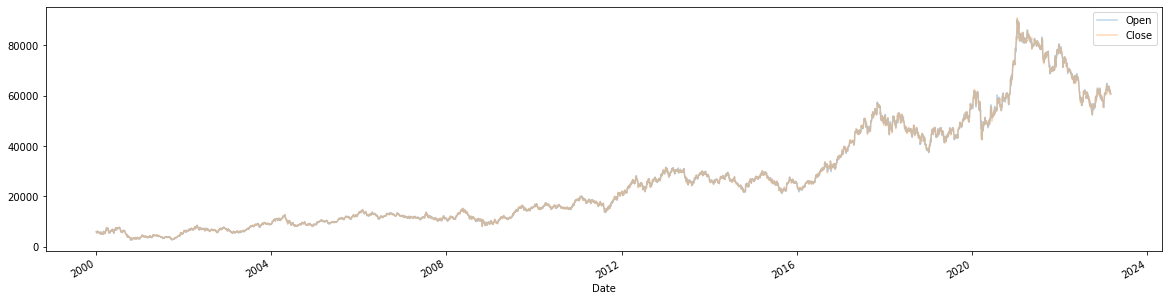

In [15]:
df[['Open', 'Close']].plot(figsize=(20,5), alpha=0.3)

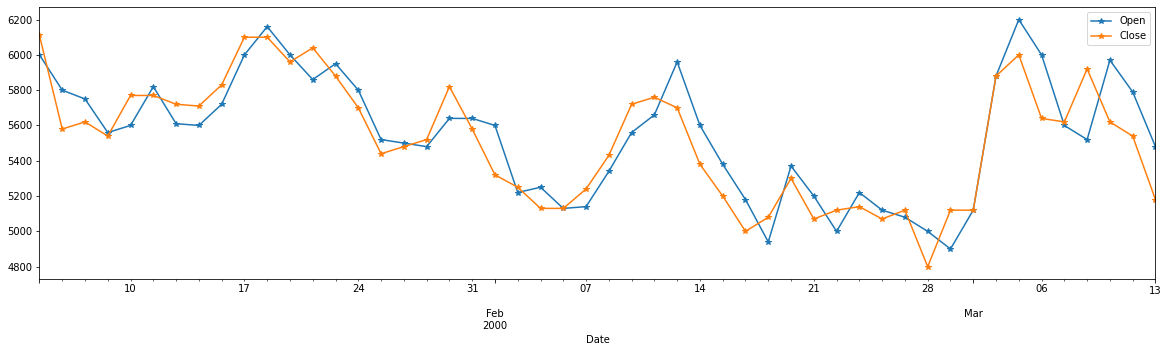

In [18]:
df[['Open', 'Close']].iloc[:50].plot(figsize=(20,5), marker='*');

In [18]:
# 결측치는 처리할 것이 없음

In [20]:
# Adj Close 컬럼 제거
df.drop(columns=['Adj Close'], inplace=True)

In [21]:
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2000-01-04,6000.0,6110.0,5660.0,6110.0,74195000
2000-01-05,5800.0,6060.0,5520.0,5580.0,74680000
2000-01-06,5750.0,5780.0,5580.0,5620.0,54390000
2000-01-07,5560.0,5670.0,5360.0,5540.0,40305000
2000-01-10,5600.0,5770.0,5580.0,5770.0,46880000


### X, y 분리

In [27]:
# y축을 close으로 / 나머지는 x축으로
df_y = df['Close'].to_frame() #Series.to_frame(): Series를 DateFrame으로 변환 => 2차원 배열혀애로 만들기 위해서
df_x = df

### Scaling - MinMaxScaler
- Scaler를 X, y 용 따로 만든다.
    - y를 inverse 하기 위해

In [63]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
y_scaler = MinMaxScaler()
X = scaler.fit_transform(df_x)
# y = df_y.values
y = y_scaler.fit_transform(df_y)

In [64]:
X.shape, y.shape

((5814, 5), (5814, 1))

In [65]:
y.max(), y.min()

(1.0, 0.0)

##  날짜 종가 예측
- X: 50일치 주가(ex:1일 ~ 50일), y: 51일째 주가. (ex: 51일)
    - 50일의 연속된 주식가격을 할습하여 51일째 주가를 예측한다.
    - X의 한개의 데이터가 50일치 주가가 된다.
<br>

![image-2.png](attachment:image-2.png)
<center>[연속된 날짜가 5인 경우]</center>

X, y를 만든다.
각 index에 window size의 데이터셋이 들어가도록 한다.

##### input sequence dataset 만들기

In [66]:
window_size = 50 #  50일치를 sequence로 묶는다.
data_x = [] # input data들을 저장할 리스트
data_y = [] # output data를 저장할 리스트

for i in range(0, y.size- window_size): 
  _X = X[i:i+window_size]   # 0~49, 1~50
  _y = y[i+window_size]    # 50.  , 51
  data_x.append(_X)
  data_y.append(_y)


In [67]:
np.shape(data_x)

(5764, 50, 5)

In [68]:
np.shape(data_y)

(5764, 1)

In [69]:
data_x[0]

array([[0.03942571, 0.03562314, 0.03720717, 0.03829161, 0.45181622],
       [0.03714676, 0.03509145, 0.03559945, 0.0322873 , 0.45476966],
       [0.03657703, 0.03211399, 0.03628847, 0.03274046, 0.33121213],
       [0.03441203, 0.03094428, 0.03376206, 0.03183415, 0.24544043],
       [0.03486782, 0.03200766, 0.03628847, 0.03443979, 0.2854794 ],
       [0.03737466, 0.0355168 , 0.03847037, 0.03443979, 0.36382182],
       [0.03498177, 0.03168864, 0.03651814, 0.03387334, 0.17793746],
       [0.03486782, 0.03168864, 0.0360588 , 0.03376005, 0.2508297 ],
       [0.03623519, 0.03317737, 0.03743684, 0.03511952, 0.3006729 ],
       [0.03942571, 0.0363675 , 0.04019293, 0.03817832, 0.38671863],
       [0.04124886, 0.03615483, 0.04088195, 0.03817832, 0.27561429],
       [0.03942571, 0.03487877, 0.04065227, 0.03659227, 0.24483147],
       [0.03783045, 0.03487877, 0.03904456, 0.03749858, 0.22723259],
       [0.03885597, 0.03424075, 0.03973358, 0.03568596, 0.19812441],
       [0.03714676, 0.03339005, 0.

In [70]:
y[0]

array([0.03829161])

## Train, Test 분리
- Train : 8, Test: 2의 비율로 나눈다.

In [71]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data_x, data_y, test_size=0.2, random_state=0)

In [72]:
np.shape(data_x), type(X_train)

((5764, 50, 5), list)

In [73]:
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

type(X_train)

numpy.ndarray

##### import

In [74]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

##### 하이퍼파라미터 정의

In [75]:
LEARNING_RATE = 0.001
N_EPOCH = 100
N_BATCH = 100

##### Dataset 생성 

In [76]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))\
                     .shuffle(X_train.shape[0]).batch(N_BATCH, drop_remainder=True)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(N_BATCH)


## Model 생성

- LSTM 레이어는 return_sequences 인자에 따라 마지막 시퀀스에서 한 번만 출력할 수 있고 각 시퀀스에서 출력을 할 수 있다. 
    - return_sequences=True: 시퀀스마다 결과를 출력. False(기본값): 전체 Sequence를 처리하고 결과를 하나만 출력
- many to many 문제를 풀거나 LSTM 레이어를 여러개로 쌓아올릴 때는 return_sequence=True 옵션을 사용. 
- Fully Connected Layer(Dense)와 연결된 경우 return_sequence=False로 해서 하나만 전달.
- 아래 그림에서 왼쪽은 return_sequences=False일 때, 오른쪽은 return_sequence=True일 때의 형상.

![image.png](attachment:image.png)

<center>[출처: https://tykimos.github.io/2017/04/09/RNN_Getting_Started]</center>

In [77]:
X_train.shape

(4611, 50, 5)

##### 모델 생성, 컴파일

In [78]:
def get_model():
    model = keras.Sequential()
    model.add(layers.InputLayer(input_shape=(window_size, 5)))
    model.add(layers.LSTM(32, return_sequences=False, activation='tanh'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1))
    
    model.compile(optimizer=keras.optimizers.Adam(LEARNING_RATE), loss='mse')
    
    return model

In [79]:
model = get_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                4864      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 5,953
Trainable params: 5,953
Non-trainable params: 0
_________________________________________________________________


##### 모델 학습, 평가

In [80]:
hist = model.fit(train_dataset, epochs=N_EPOCH, validation_data=test_dataset)

Epoch 1/100
46/46 [==============================] - 6s 41ms/step - loss: 0.0043 - val_loss: 2.7538e-04
Epoch 2/100
46/46 [==============================] - 2s 32ms/step - loss: 1.8444e-04 - val_loss: 1.2941e-04
Epoch 3/100
46/46 [==============================] - 1s 28ms/step - loss: 1.1473e-04 - val_loss: 1.0777e-04
Epoch 4/100
46/46 [==============================] - 1s 27ms/step - loss: 9.9097e-05 - val_loss: 1.0027e-04
Epoch 5/100
46/46 [==============================] - 1s 27ms/step - loss: 9.4988e-05 - val_loss: 9.5985e-05
Epoch 6/100
46/46 [==============================] - 1s 27ms/step - loss: 9.3692e-05 - val_loss: 9.0211e-05
Epoch 7/100
46/46 [==============================] - 2s 33ms/step - loss: 9.2961e-05 - val_loss: 9.2975e-05
Epoch 8/100
46/46 [==============================] - 2s 43ms/step - loss: 9.5145e-05 - val_loss: 8.7579e-05
Epoch 9/100
46/46 [==============================] - 1s 28ms/step - loss: 9.0705e-05 - val_loss: 8.8050e-05
Epoch 10/100
46/46 [============

##### 결과 시각화

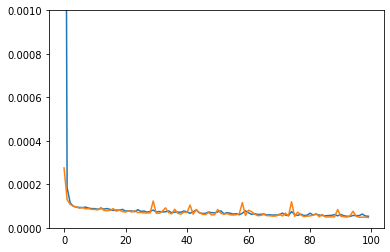

In [81]:
plt.plot(hist.epoch, hist.history['loss'])
plt.plot(hist.epoch, hist.history['val_loss']);
plt.ylim(0,0.001)
plt.show()


##### 최종평가

In [82]:
model.evaluate(test_dataset)

12/12 [==============================] - 0s 14ms/step - loss: 4.7418e-05


4.74183980259113e-05

##### 다음날 주가 예측
- 마지막 50일치로 내일 주가를 예측해 본다.

In [83]:
X[-50:][np.newaxis, ...].shape

(1, 50, 5)

In [84]:
new_data = X[-50:][np.newaxis, ...]
new_data.shape

(1, 50, 5)

In [85]:
pred = model.predict(new_data)

1/1 [==============================] - 1s 538ms/step


In [86]:
pred

array([[0.65690154]], dtype=float32)

In [87]:
y_scaler.inverse_transform(pred)

array([[60714.7]], dtype=float32)

# TOFO_cifo10_다른 방법을 통해서 성능 올려보기(이전 0.83)
